Bacon-Shor code
==============

A simulation of the Bacon-Shor code is carried out based on the work by Egan [1].  The aim work is to validate the noise model for use on the Steane code.  

The Bacon-Shor code with ancilla is set up following the Extended Figure One of Egan's paper.

First, the logical zero or logical one state are encoded.  Errors in logical state preparation are found by evaluating  parities.  These resuls are with Egan's paper.

Errors are introduced by applying X or Z Pauli gates to specified qubits.  The population of the ancilla qubits are compared with those found by Egan.

To have a good fit with Egan's results the two gate depolarising error parameter needs to be approxmately double that of quoted by Egan.  These higher errors may be more suitable for the Steane code simulation because there is more noise from cross talk for a complex circuit.

This is part of an MSc project on the Steane code.  Please see https://goldsmdn.github.io/ for full details.

[1] Egan L, Debroy DM, Noel C, Risinger A, Zhu D, Biswas D, et al. Fault-Tolerant Operation of a Quantum Error-Correction Code. arXiv Available from: http://arxiv.org/abs/2009.11482

This worksheet is run with two gate de-polarising noise of 0.011.

Import the necessary function modules.

In [1]:
from qiskit import(
    QuantumCircuit,
    QuantumRegister,
    ClassicalRegister,
    execute,
    Aer
    )

from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
from qiskit.compiler import transpile

import matplotlib.pyplot as plt
import numpy as np

from helper_functions import (
    find_individual_ancilla_values,
    find_ancilla_values,
    find_parity,
    get_noise,
    mean_of_list,
    calculate_standard_error
    )

from circuits import BaconShorCodeLogicalQubit

Define constants so the process flow can be controlled from one place:

In [2]:
SINGLE_GATE_SET = ['id', 'ry', 'rx']
TWO_GATE_SET = ['rxx']
BASIS_GATE_SET = SINGLE_GATE_SET + TWO_GATE_SET

Z_LOGICAL = True

BLOCKS = 3
DATA_QUBITS = BLOCKS ** 2
ANCILLAS = 2
ANCILLA_QUBITS = ANCILLAS ** 2
MEASURE_Z = True

ITERATIONS = 25
#25 iterations will take several minutes.  It might be better to run with fewer.

NOISE = True                             #Test with noise
SHOTS = 10000                            #Number of shots to run    
MEASURE_NOISE = 0.0046                   #Measurement noise not relevant
SINGLE_GATE_DEPOLARISING = 0.000366      #Single gate noise   
TWO_GATE_DEPOLARISING = 0.011            #Two gate noise

SIMULATOR = Aer.get_backend('qasm_simulator')

Run circuit and calculate results for logical_one and logical_zero. Iterate a number of times to find standard error.

In [3]:
values_list = []
#values for graph
values_graph = []
standard_error_graph = []
labels_graph = []

for logical_one in [False, True]:
    print(f'Results for logical one {logical_one}') 
    if logical_one:
        labels_graph.append('|1L>')
    else:
        labels_graph.append('|0L>')
    values_list = []
    for iteration in range(ITERATIONS):
        qubit = BaconShorCodeLogicalQubit(1, DATA_QUBITS, ANCILLA_QUBITS, ANCILLAS, 
                                          BLOCKS, logical_one, Z_LOGICAL)
        qubit.encoding_nft()
        qubit.encoding_ft()
        if NOISE:
            noise_model = get_noise(MEASURE_NOISE, SINGLE_GATE_DEPOLARISING, TWO_GATE_DEPOLARISING, 
                                    SINGLE_GATE_SET, TWO_GATE_SET)
        qubit.logical_measure()
        qt = transpile(qubit, basis_gates = BASIS_GATE_SET)

        if NOISE:
            result = execute(qt, SIMULATOR, noise_model = noise_model, shots = SHOTS).result()
        else:
            result = execute(qt, SIMULATOR, shots = SHOTS).result()

        counts = result.get_counts(qt)
        parity_values = find_parity(counts, DATA_QUBITS)
        if logical_one:
            #matching Egan's calculations
            ideal = -1 
            measure = -1 * parity_values.get('1') / SHOTS
            difference = ideal - measure
            values_list.append(difference) 
        else:
            #logical zero
            ideal = 1
            measure = 1 * parity_values.get('0') / SHOTS
            difference = ideal - measure
            values_list.append(difference) 
    mean = mean_of_list(values_list)     
    values_graph.append(mean)
    standard_deviation, standard_error = calculate_standard_error(values_list)
    standard_error_graph.append(standard_error)
    
    print(f'The difference is {mean:.4f}')
    print(f'The standard_deviation is {standard_deviation:.4f} and the standard error is {standard_error:.4f}')

Results for logical one False
The difference is 0.1143
The standard_deviation is 0.0035 and the standard error is 0.0007
Results for logical one True
The difference is -0.1166
The standard_deviation is 0.0023 and the standard error is 0.0005


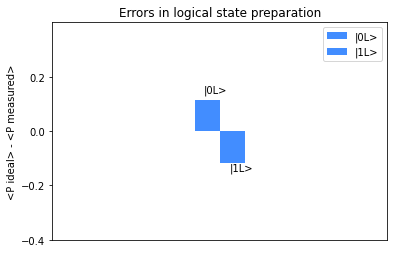

In [4]:
#graph constants
YMIN = -0.4
YMAX = 0.4
YTICK = 0.2
XMIN = -0.2
XMAX = 0.2
SIZE = 20

x = np.arange(len(labels_graph))  # the bar locations
width = 0.03  # the width of the bars
bar_width = 5 #width of error bars

fig, ax = plt.subplots()
rects0 = ax.bar(x - width/2, values_graph[0], width, label = labels_graph[0], 
                color = '#428dff')
rects1 = ax.bar(x + width/2, values_graph[1], width, label = labels_graph[1], 
                color = '#428dff')
plt.errorbar(-width/2, values_graph[0], xerr = 0, yerr = standard_error_graph[0], 
             color = 'black', fmt = 'none', elinewidth = bar_width)
plt.errorbar( width/2, values_graph[1], xerr = 0, yerr = standard_error_graph[1], 
             color = 'black', fmt = 'none', elinewidth = bar_width)

ax.set_ylabel('<P ideal> - <P measured>')
ax.set_title('Errors in logical state preparation')
ax.legend()
plt.ylim(YMIN, YMAX)
plt.yticks(np.arange(YMIN, YMAX, YTICK))
plt.xlim(XMIN, XMAX)
ax.axes.xaxis.set_ticks([])

# print labels on top of or on bottom of bars
for i in range(len(labels_graph)):
    plt.text(x = i * width - 1.25 * width/2, y = 1.25 * values_graph[i], s = labels_graph[i], size = 10)

fname = "Bacon_Shor_errors_in_logical_state_graph1.png"
plt.savefig(fname)

Here are the actual observations from Egan for comparison.  The blue columns fault tolerant bars are comparable.
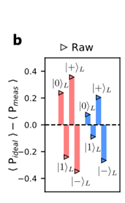

Print out circuit:

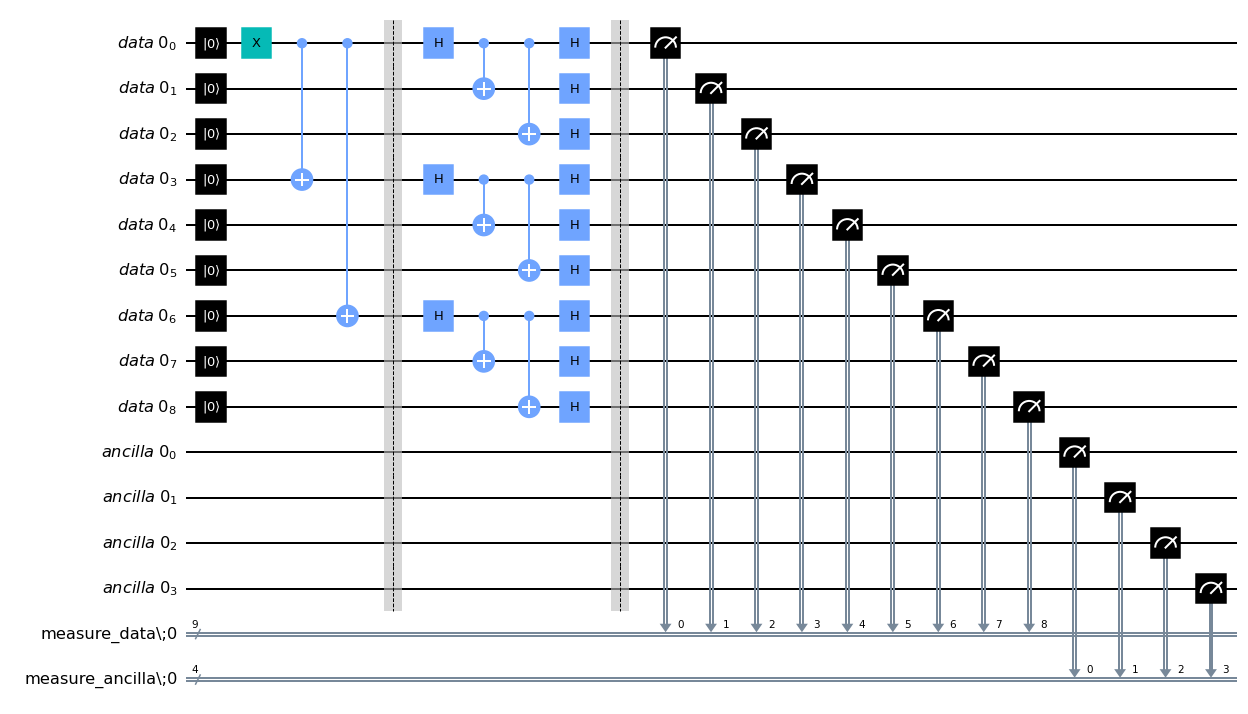

In [5]:
qubit.draw(output = 'mpl', filename = 'Bacon_Shor_encoding_circuit.jpg', fold = 60)

Print out transpiled circuit

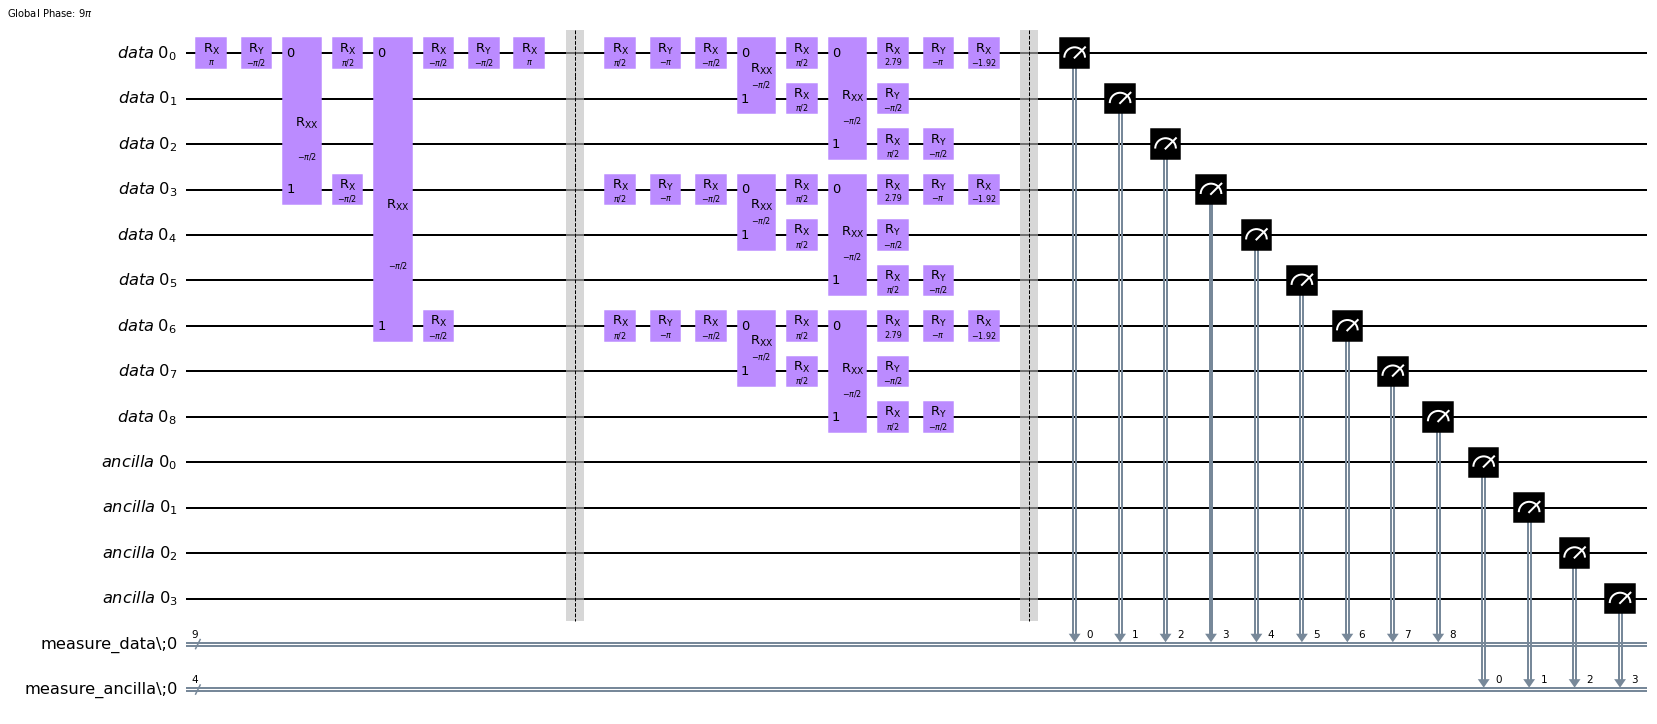

In [6]:
qt.draw(output='mpl', filename = 'Bacon_Shor_encoding_circuit_transpiled.jpg', fold = 60)

Run with different X, Z errors as per Egan paper and find the ancilla populations.

In [7]:
#initialise lists for graphs results and calculations
values_graph = [[] for i in range(DATA_QUBITS + 1,DATA_QUBITS + 1 + ANCILLA_QUBITS)]
standard_error_graph = [[] for i in range(DATA_QUBITS + 1,DATA_QUBITS + 1 + ANCILLA_QUBITS)]
index_list = [str(i) for i in range(DATA_QUBITS + 1,DATA_QUBITS + 1 + ANCILLA_QUBITS)]
labels_graph = ['Ancilla qubit ' + str(i) for i in range(DATA_QUBITS + 1, DATA_QUBITS + 1 + ANCILLA_QUBITS)]

cases_list = []

runs = {'I':{},
        'Z2':{'test_z_qubit': 1},
        'X5':{'test_x_qubit': 4},
        'Y1':{'test_x_qubit': 0,'test_z_qubit': 0},
        'Y5':{'test_x_qubit': 4,'test_z_qubit': 4}
       }

#Egan labels the qubits starting at 1 and quiskit uses 0, so need to adjust accordingly
for cases, parameters in runs.items():
    print("For case", cases)
    values_list = [[] for i in range(DATA_QUBITS + 1,DATA_QUBITS + 1 + ANCILLA_QUBITS)]
    for iteration in range(ITERATIONS):
        #print(f'Iteration {iteration}')
        test_x = True
        if 'test_x_qubit' in parameters:
            x_bit = parameters.get('test_x_qubit')
        else:
            test_x = False
        test_z = True
        if 'test_z_qubit' in parameters:
            z_bit = parameters.get('test_z_qubit')
        else:
            test_z = False
        qubit = BaconShorCodeLogicalQubit(1, DATA_QUBITS, ANCILLA_QUBITS, ANCILLAS, 
                                          BLOCKS, logical_one, Z_LOGICAL)
        qubit.reset_stabilizers()
        qubit.encoding_nft()
        qubit.encoding_ft()
        if test_x:
            qubit.x_testing(0, x_bit)
        if test_z:
            qubit.z_testing(0, z_bit)
        qubit.x_stabilizers()
        qubit.z_stabilizers()
        if NOISE:
            noise_model = get_noise(MEASURE_NOISE, SINGLE_GATE_DEPOLARISING, TWO_GATE_DEPOLARISING, 
                                    SINGLE_GATE_SET, TWO_GATE_SET)
        qubit.logical_measure()

        qt = transpile(qubit, basis_gates = BASIS_GATE_SET)

        if NOISE:
            result = execute(qt, SIMULATOR, noise_model = noise_model, shots = SHOTS).result()
        else:
            result = execute(qt, SIMULATOR, shots = SHOTS).result()

        counts = result.get_counts(qt)

        ancilla_values = find_ancilla_values(counts, ANCILLA_QUBITS)
        #print('The population of different ancilla bitstrings are', ancilla_values)
        #print()
        individual_ancilla_values = find_individual_ancilla_values(ancilla_values, DATA_QUBITS, ANCILLA_QUBITS)
        #print('By ancilla number the populations are ', individual_ancilla_values)
        #print()
        index = 0
        for labels in index_list:
            values_list[index].append(individual_ancilla_values.get(labels) / SHOTS)
            index = index + 1
    cases_list.append(cases)
    index = 0
    print(f'Summary of results for case {cases}')
    for labels in index_list:
        mean = mean_of_list(values_list[index])
        print(f' The mean for index {index} with label {labels_graph[index]} is {mean:.4f}')
        standard_deviation, standard_error = calculate_standard_error(values_list[index])
        print(f' The standard error for index {index} is {standard_error:.4f}')
        values_graph[index].append(mean)
        standard_error_graph[index].append(standard_error)
        index = index + 1
    #print('values_graph', values_graph )
    #print('standard_error_graph', standard_error_graph )         

For case I
Summary of results for case I
 The mean for index 0 with label Ancilla qubit 10 is 0.1474
 The standard error for index 0 is 0.0006
 The mean for index 1 with label Ancilla qubit 11 is 0.1581
 The standard error for index 1 is 0.0007
 The mean for index 2 with label Ancilla qubit 12 is 0.0850
 The standard error for index 2 is 0.0006
 The mean for index 3 with label Ancilla qubit 13 is 0.0979
 The standard error for index 3 is 0.0005
For case Z2
Summary of results for case Z2
 The mean for index 0 with label Ancilla qubit 10 is 0.1480
 The standard error for index 0 is 0.0007
 The mean for index 1 with label Ancilla qubit 11 is 0.1595
 The standard error for index 1 is 0.0007
 The mean for index 2 with label Ancilla qubit 12 is 0.9141
 The standard error for index 2 is 0.0006
 The mean for index 3 with label Ancilla qubit 13 is 0.9013
 The standard error for index 3 is 0.0007
For case X5
Summary of results for case X5
 The mean for index 0 with label Ancilla qubit 10 is 0.85

The input circuit can be drawn

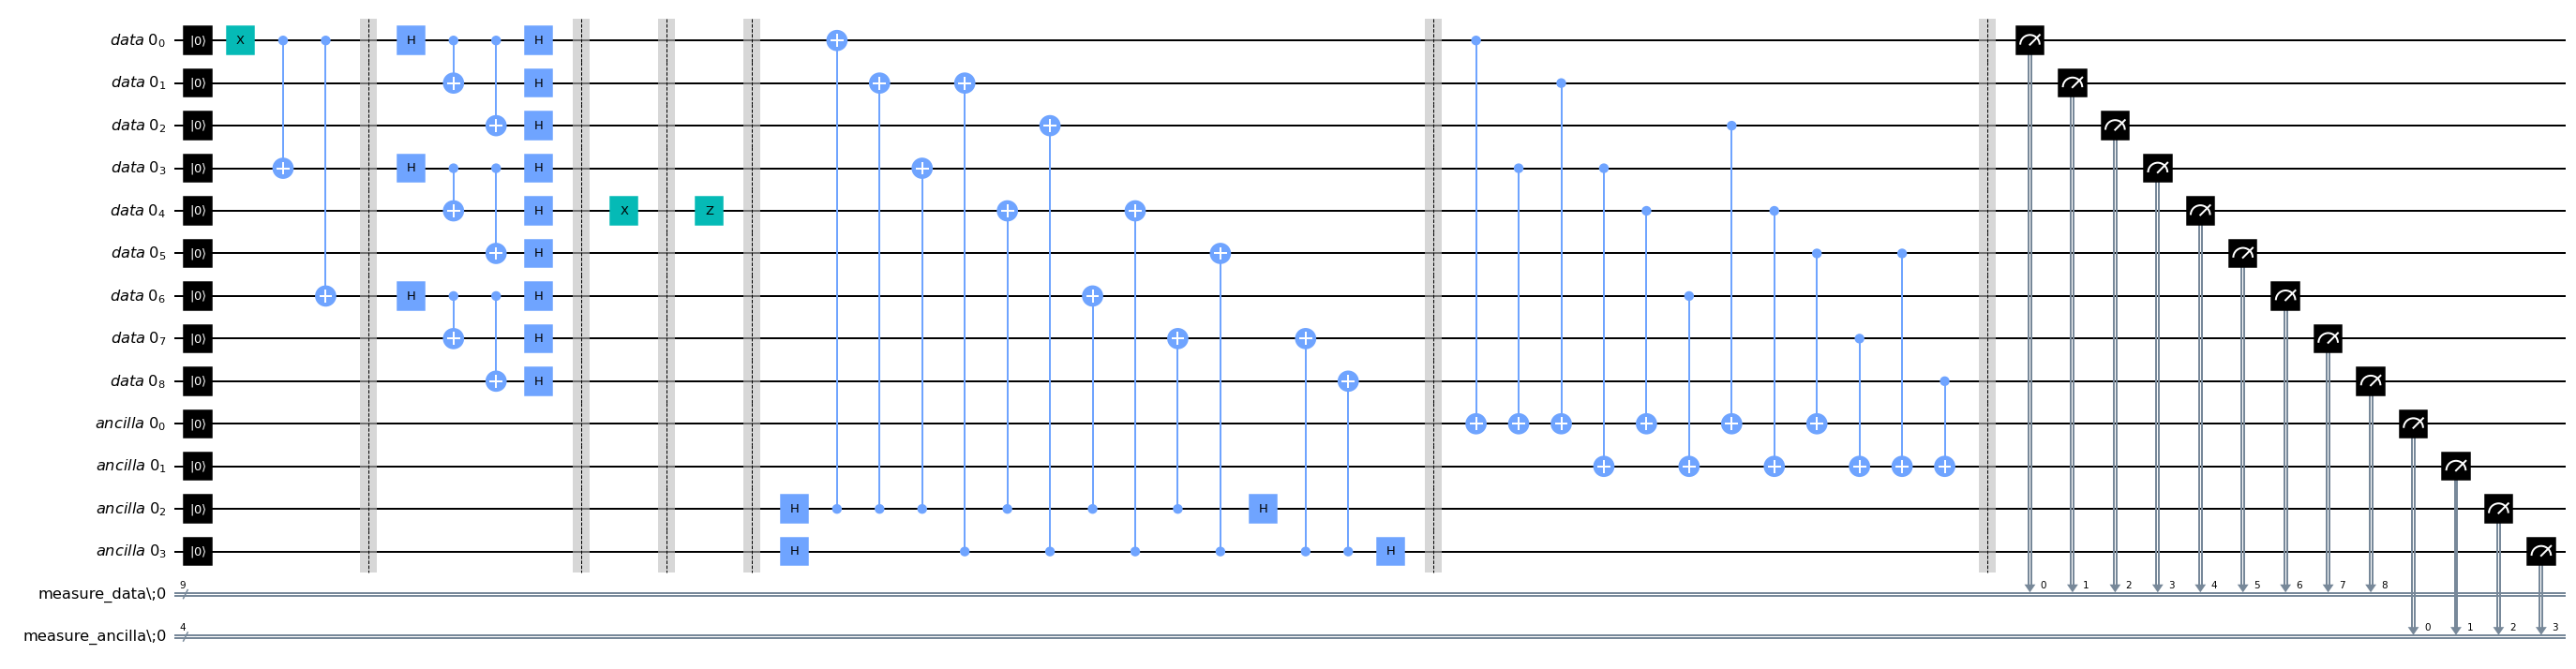

In [8]:
qubit.draw(output='mpl', filename = 'Bacon_Shor_full_circuit.jpg', fold = 60)

The transpiled circuit can be drawn

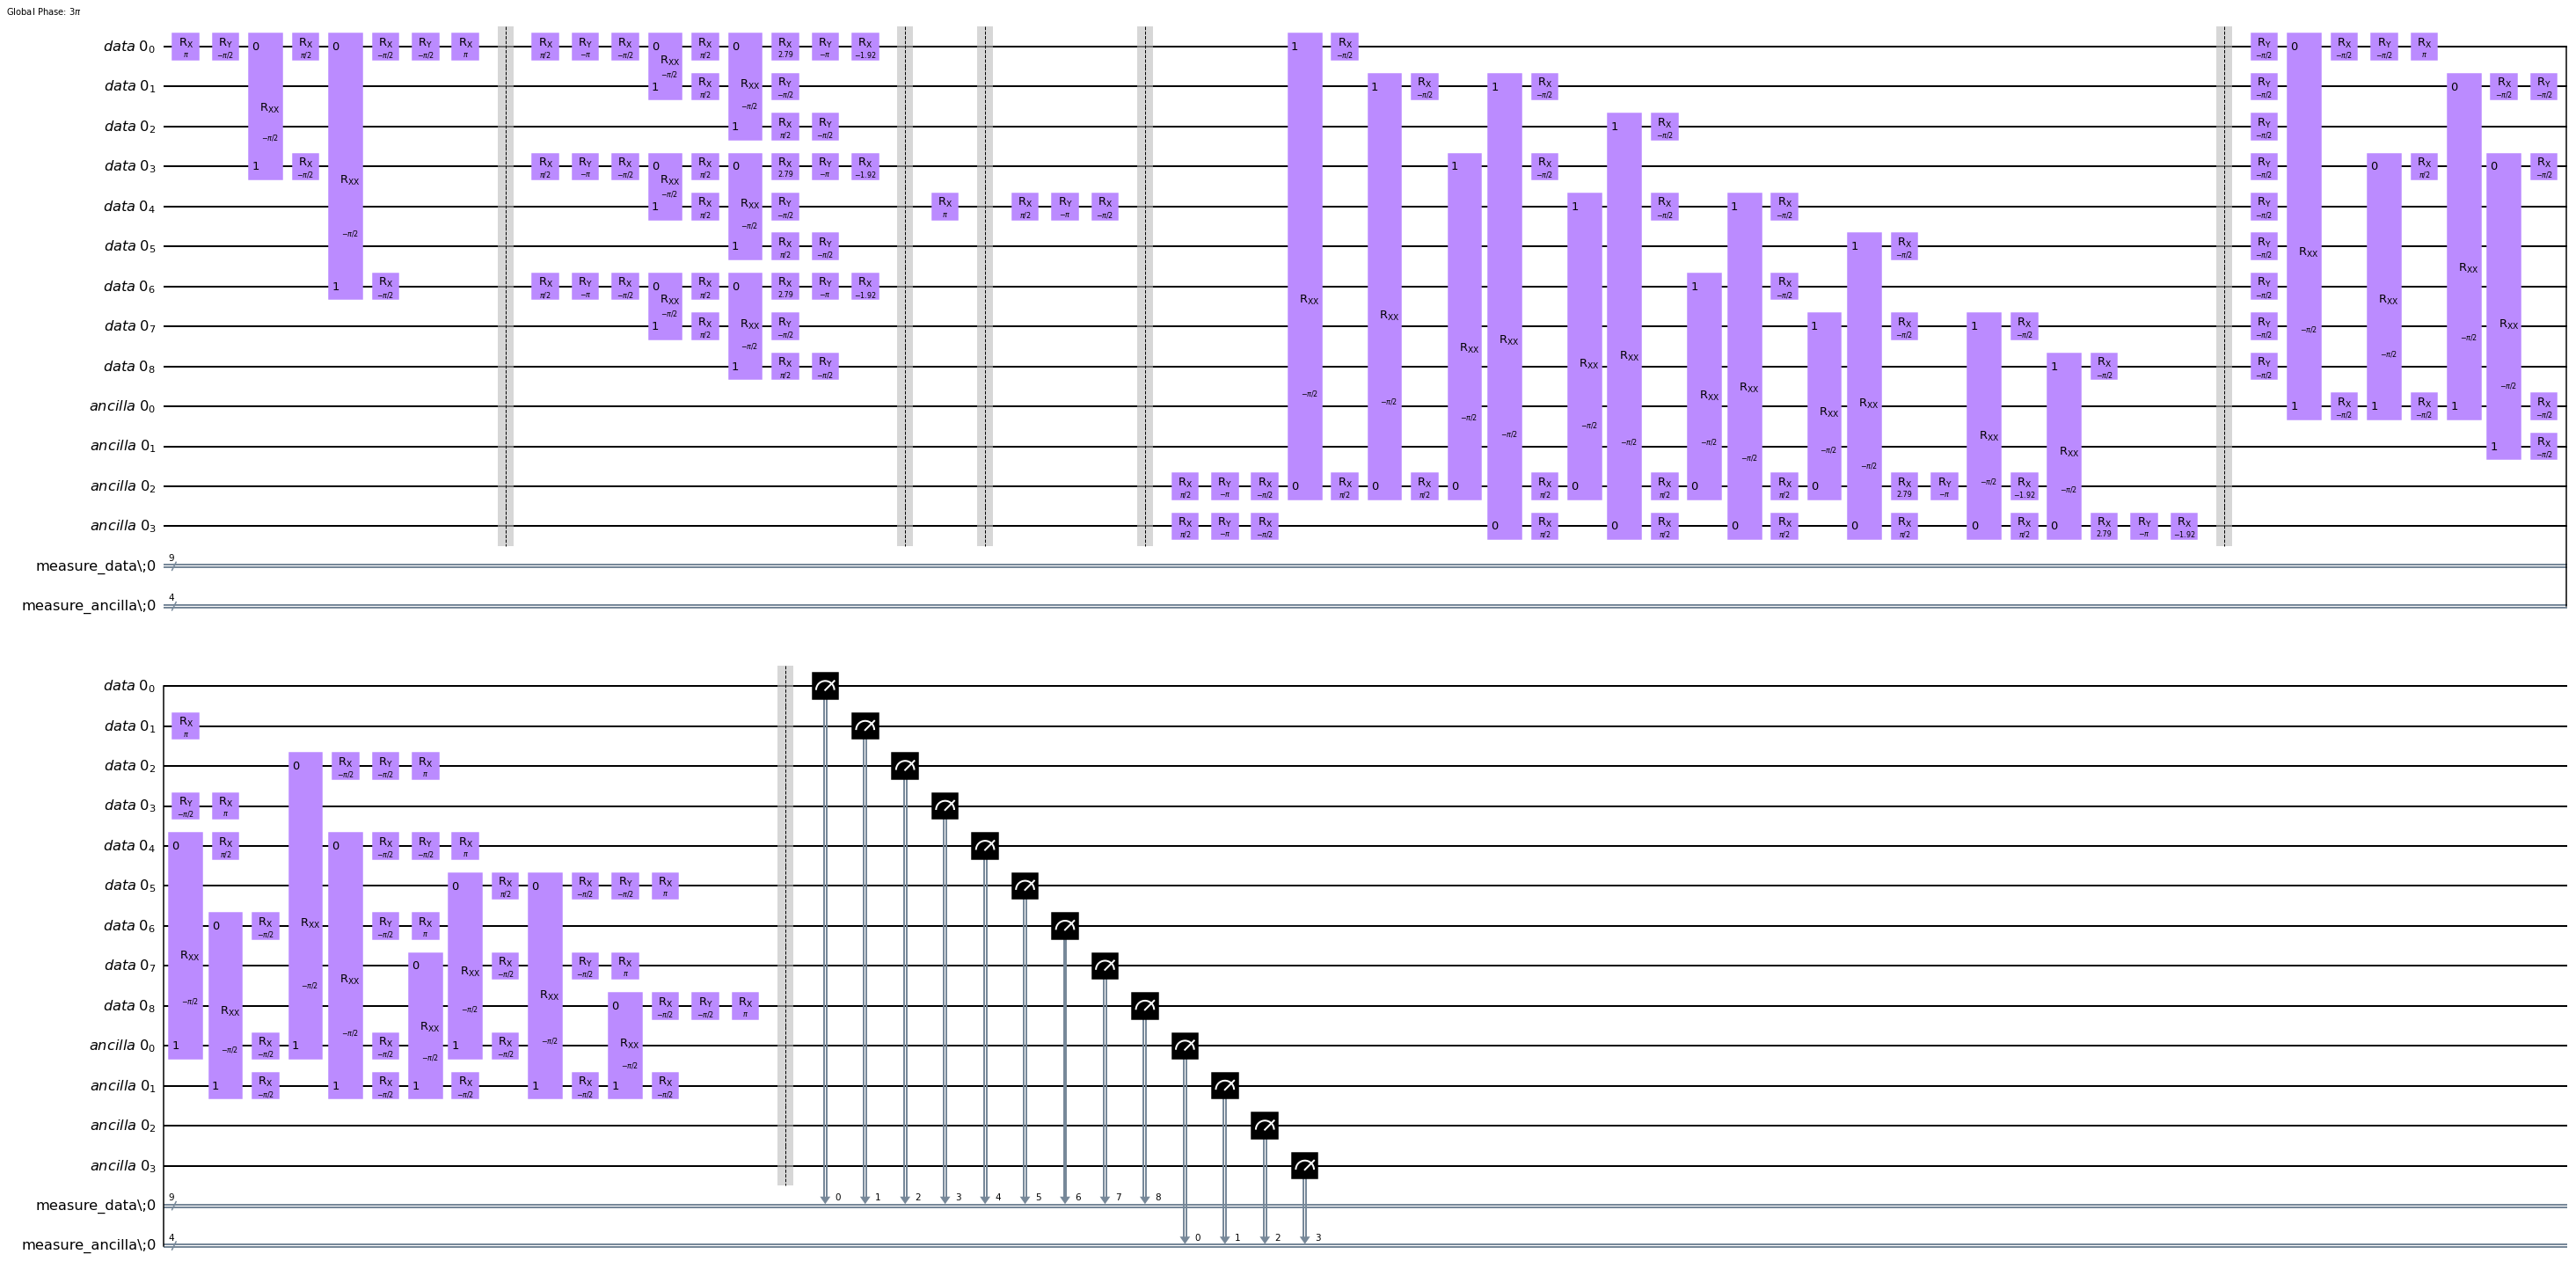

In [9]:
qt.draw(output='mpl', filename = 'Bacon_Shor_full_circuit_transpiled.jpg', fold = 60)

Plot graph of results

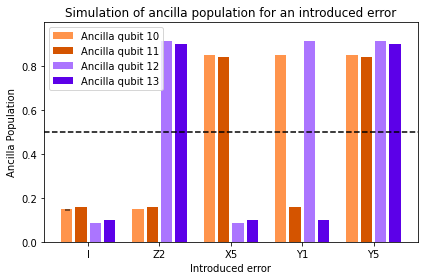

In [11]:
#graph constants
YMIN = 0
YMAX = 1.0
YTICK = 0.2
WIDTH = 0.2
GAP = .8

x = np.arange(len(cases_list))  # the label locations

fig, ax = plt.subplots()
plt.bar(x - WIDTH * 3 / 2, values_graph[0], color = '#ff944c', width = WIDTH * GAP, 
        label = labels_graph[0])
plt.bar(x - WIDTH / 2, values_graph[1], color = '#d45400', width = WIDTH * GAP, 
        label = labels_graph[1])
plt.bar(x + WIDTH / 2, values_graph[2], color = '#ab75ff', width = WIDTH * GAP, 
        label = labels_graph[2])
plt.bar(x + WIDTH * 3 /2, values_graph[3], color = '#5c00e8', width = WIDTH * GAP, 
        label = labels_graph[3])

plt.errorbar(x -  WIDTH * 3 / 2, values_graph[0], xerr = 0 , yerr = standard_error_graph[0], 
             color = 'black', fmt = 'none', elinewidth = bar_width)
plt.errorbar(x - WIDTH / 2, values_graph[1], xerr = 0, yerr = standard_error_graph[1], 
             color = 'black', fmt = 'none', elinewidth = bar_width)
plt.errorbar(x + WIDTH / 2, values_graph[2], xerr = 0, yerr = standard_error_graph[2], 
             color = 'black', fmt = 'none', elinewidth = bar_width)
plt.errorbar(x + WIDTH * 3 /2, values_graph[3], xerr = 0, yerr = standard_error_graph[3], 
             color = 'black', fmt = 'none', elinewidth = bar_width)

plt.axhline(y = 0.5, color = 'black', linestyle = 'dashed')
ax.set_ylabel('Ancilla Population')
ax.set_xlabel('Introduced error')
ax.set_title('Simulation of ancilla population for an introduced error')
ax.set_xticks(x)
ax.set_xticklabels(cases_list)
ax.legend()

plt.ylim(YMIN, YMAX)
plt.yticks(np.arange(YMIN, YMAX, YTICK))

fig.tight_layout()

fname = "Bacon_Shor_ancilla_graph1.png"
plt.savefig(fname)

Here are the actual observations from Egan for comparison:

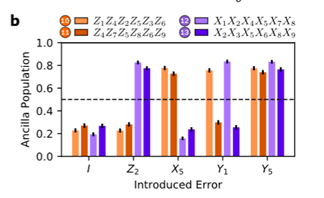